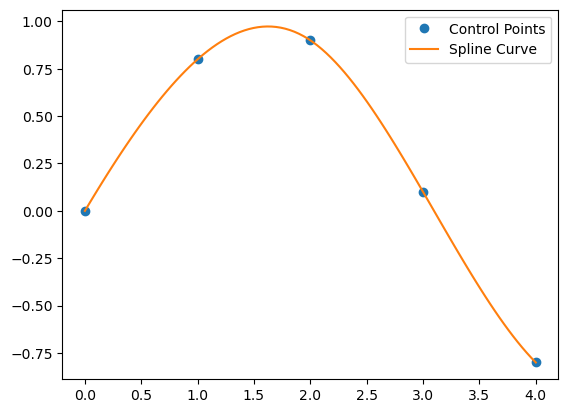

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

# Define input points
x = np.array([0, 1, 2, 3, 4])
y = np.array([0, 0.8, 0.9, 0.1, -0.8])

# Fit spline to points (cubic by default)
spline_params = splrep(x, y)

# Generate smooth curve
x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = splev(x_smooth, spline_params)

# Plot
plt.plot(x, y, 'o', label='Control Points')
plt.plot(x_smooth, y_smooth, '-', label='Spline Curve')
plt.legend()
plt.show()

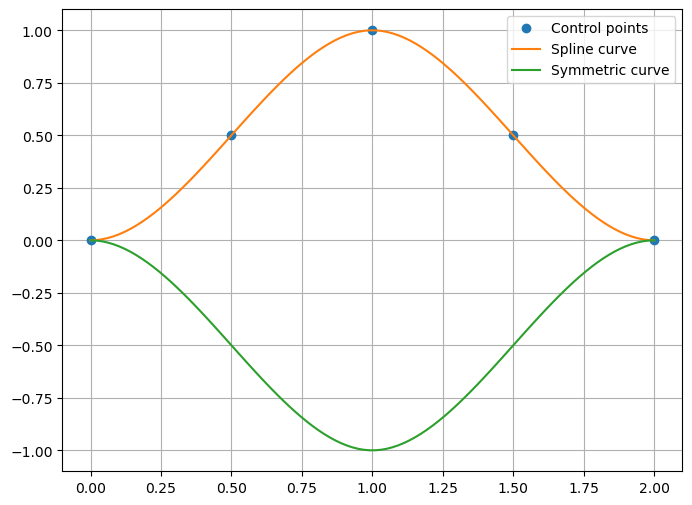

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

x = np.array([0, 0.5, 1, 1.5, 2])
y = np.array([0, 0.5, 1, 0.5, 0])

spline_params = splrep(x, y)
x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = splev(x_smooth, spline_params)

# Create symmetric version
y_sym = -y_smooth
x_sym = x_smooth

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, 'o', label='Control points')
plt.plot(x_smooth, y_smooth, "-", label='Spline curve')
plt.plot(x_sym, y_sym, "-", label='Symmetric curve')
plt.legend()
plt.grid(True)
plt.show()

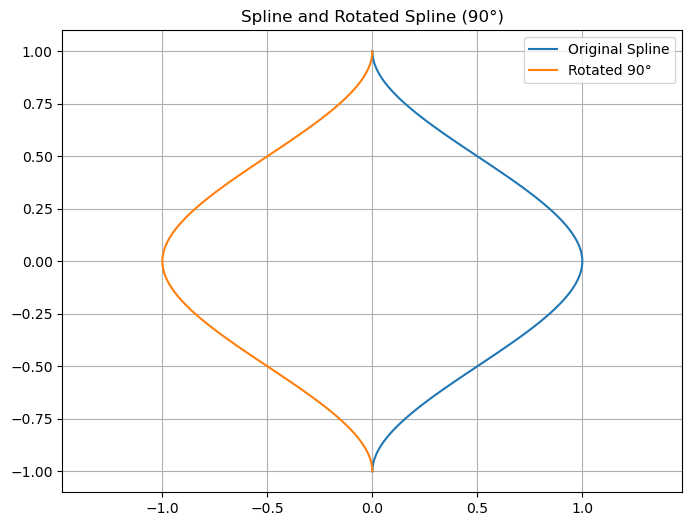

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

# Define control points
x = np.array([0, 0.5, 1, 1.5, 2])
y = np.array([0, 0.5, 1, 0.5, 0])

# Spline interpolation
spline_params = splrep(x, y)
x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = splev(x_smooth, spline_params)

# Create symmetric version
y_sym = -y_smooth
x_sym = x_smooth

# 90-degree rotation matrix
theta = np.pi / 2  # 90 degrees in radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]])

# Stack the points as (2, N)
original_points = np.vstack((x_smooth, y_smooth))
original_points_sym = np.vstack((x_sym, y_sym))


# Apply rotation
rotated_points = rotation_matrix @ original_points
rotated_points_sym = rotation_matrix  @ original_points_sym
x_rotated, y_rotated = rotated_points
x_rotated_sym, y_rotated_sym = rotated_points_sym

curve1 = np.stack((x_rotated, y_rotated-np.ones(len(y_smooth))))
curve2 = np.stack((x_rotated_sym, y_rotated_sym-np.ones(len(y_smooth))))
curves = [curve1, curve2]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_rotated_sym, y_rotated_sym-np.ones(len(y_smooth)), '-', label='Original Spline')
plt.plot(x_rotated, y_rotated-np.ones(len(y_smooth)), '-', label='Rotated 90°')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title("Spline and Rotated Spline (90°)")
plt.show()

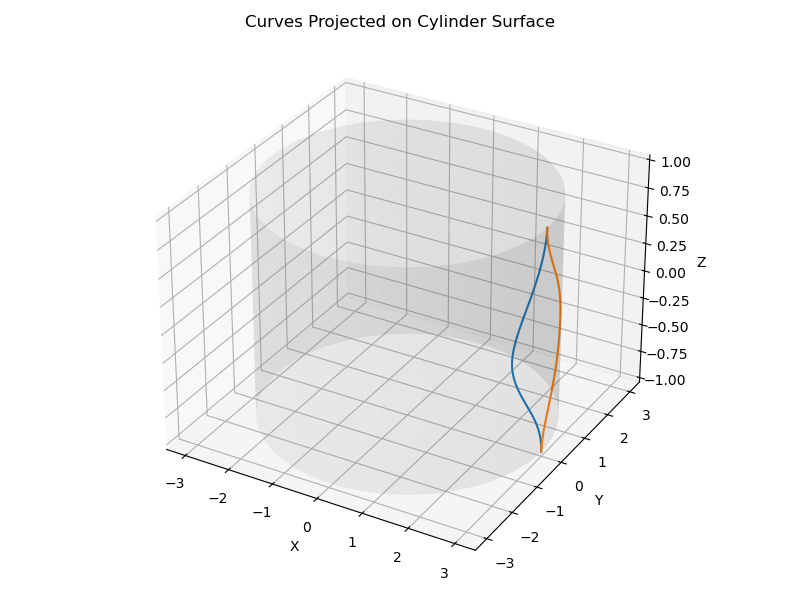

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget 

curves_cylinder = []
cylinder_radius = 3.0

for curve in curves:
    curve_projected = []
    theta = curve[0] / cylinder_radius 
    X = cylinder_radius * np.cos( theta )
    Y = cylinder_radius * np.sin( theta )
    Z = curve[1]
    curve_projected.append((X,Y,Z))
    curve_projected_stack = np.column_stack(curve_projected)
    curves_cylinder.append(curve_projected_stack)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for curve in curves_cylinder:
    x, y, z = curve[0], curve[1], curve[2]
    ax.plot3D(x, y, z)

# Draw the cylinder
theta_cyl = np.linspace(0, 2 * np.pi, 100)
z_cyl = np.linspace(-1, 1, 100)
theta_cyl, z_cyl = np.meshgrid(theta_cyl, z_cyl)
x_cyl = cylinder_radius * np.cos(theta_cyl)
y_cyl = cylinder_radius * np.sin(theta_cyl)

ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Curves Projected on Cylinder Surface')
plt.tight_layout()
plt.show()


In [5]:
curves_cylinder[0][2][99]

np.float64(1.0)

In [7]:
# Step 5: Read the Fusion 360 script
with open('elastica.py', 'r') as file:
    lines = file.readlines()

# Step 6: Locate code generation section
start_idx = None
end_idx = None

for i, line in enumerate(lines):
    if '# START CODE GENERATION SECTION DO NOT REMOVE COMMENTS' in line:
        start_idx = i
    if '# END CODE GENERATION SECTION DO NOT REMOVE COMMENTS' in line:
        end_idx = i

if start_idx is None or end_idx is None or start_idx >= end_idx:
    raise ValueError("Code generation section not found or improperly formatted.")

marker_to_var = {}  
generated_code = []
generated_code.append('\n')
for i in range(len(curves_cylinder)):
    generated_code.append(f'        sketch{i} = sketches.add(rootComp.xYConstructionPlane)\n')
    generated_code.append(f'        sketch{i}.is3D = True\n')
    generated_code.append(f'        pts{i} = adsk.core.ObjectCollection.create()\n')
    for j in range(len(curves_cylinder[i][0])):
        var_name = f'p{i}_{j}'
        generated_code.append(f'        pts{i}.add(adsk.core.Point3D.create({curves_cylinder[i][0][j]}, {curves_cylinder[i][1][j]}, {curves_cylinder[i][2][j]}))\n')
    generated_code.append(f'        spline{i} = sketch{i}.sketchCurves.sketchFittedSplines.add(pts{i})\n')
    generated_code.append('\n\n')
   
        
generated_code.append('\n\n')

generated_code.append(f'        pathCurves{i} = adsk.core.ObjectCollection.create()\n')
generated_code.append(f'        pathCurves{i}.add(spline{0})\n')
generated_code.append(f'        pathCurves{i}.add(spline{2})\n')
generated_code.append('\n\n')

generated_code.append(f'        patches = rootComp.features.patchFeatures\n')
generated_code.append(f'        patchInput = patches.createInput(pathCurves{i}, adsk.fusion.FeatureOperations.NewBodyFeatureOperation)\n')
generated_code.append(f'        patch{i} = patches.add(patchInput)\n')

generated_code.append('\n')


new_lines = lines[:start_idx + 1] + generated_code + lines[end_idx:]

with open('elastica.py', 'w') as file:
    file.writelines(new_lines)

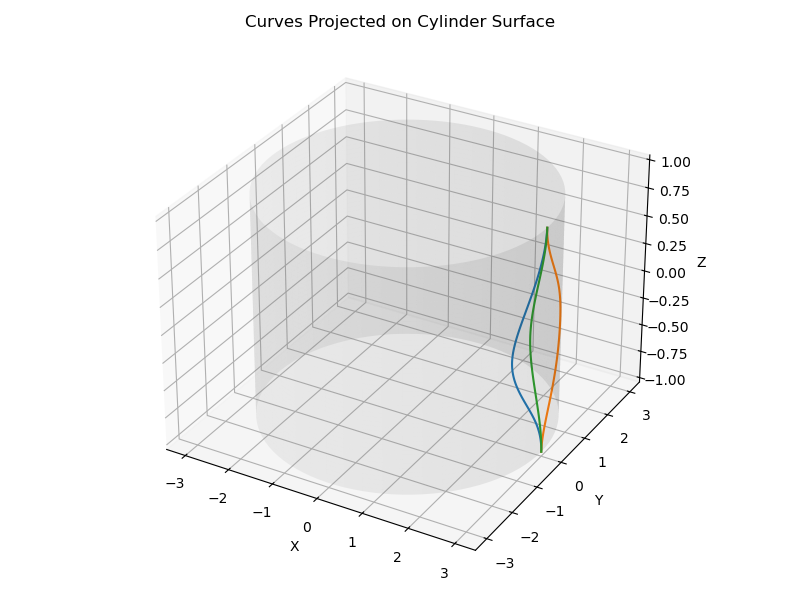

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

x = np.array([0, 0.5, 1, 1.5, 2])
y = np.array([0, 0.15, 0.3, 0.15, 0])

spline_params = splrep(x, y)
x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = splev(x_smooth, spline_params)

# 90-degree rotation matrix
n = 1 
theta = n*(np.pi / 2)  # 90 degrees in radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]])

# Stack the points as (2, N)
original_points = np.vstack((x_smooth, y_smooth))
original_points_sym = np.vstack((x_sym, y_sym))


# Apply rotation
rotated_points = rotation_matrix @ original_points
x_rotated, z_rotated = rotated_points
curve3 = np.stack((x_rotated + np.ones(len(y_smooth))*cylinder_radius , np.zeros(len(y_smooth)), z_rotated-np.ones(len(y_smooth))))



fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for curve in curves_cylinder:
    x, y, z = curve[0], curve[1], curve[2]
    ax.plot3D(x, y, z)

ax.plot3D(curve3[0], curve3[1], curve3[2])

# Draw the cylinder
theta_cyl = np.linspace(0, 2 * np.pi, 100)
z_cyl = np.linspace(-1, 1, 100)
theta_cyl, z_cyl = np.meshgrid(theta_cyl, z_cyl)
x_cyl = cylinder_radius * np.cos(theta_cyl)
y_cyl = cylinder_radius * np.sin(theta_cyl)

ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Curves Projected on Cylinder Surface')
plt.tight_layout()
plt.show()

In [10]:
# Step 5: Read the Fusion 360 script
with open('elastica.py', 'r') as file:
    lines = file.readlines()

# Step 6: Locate code generation section
start_idx = None
end_idx = None

for i, line in enumerate(lines):
    if '# START CODE GENERATION SECTION DO NOT REMOVE COMMENTS' in line:
        start_idx = i
    if '# END CODE GENERATION SECTION DO NOT REMOVE COMMENTS' in line:
        end_idx = i

if start_idx is None or end_idx is None or start_idx >= end_idx:
    raise ValueError("Code generation section not found or improperly formatted.")

marker_to_var = {}  
generated_code = []
generated_code.append('\n')
for i in range(len(curves_cylinder)):
    generated_code.append(f'        sketch{i} = sketches.add(rootComp.xYConstructionPlane)\n')
    generated_code.append(f'        sketch{i}.is3D = True\n')
    generated_code.append(f'        pts{i} = adsk.core.ObjectCollection.create()\n')
    for j in range(len(curves_cylinder[i][0])):
        var_name = f'p{i}_{j}'
        generated_code.append(f'        pts{i}.add(adsk.core.Point3D.create({curves_cylinder[i][0][j]}, {curves_cylinder[i][1][j]}, {curves_cylinder[i][2][j]}))\n')
    generated_code.append(f'        spline{i} = sketch{i}.sketchCurves.sketchFittedSplines.add(pts{i})\n')
    generated_code.append('\n\n')

for j in range(len(curve3[0])):
    generated_code.append(f'        pts{3}.add(adsk.core.Point3D.create({curve3[0][j]}, {curve3[1][j]}, {curve3[2][j]}))\n')
generated_code.append(f'        spline{3} = sketch{3}.sketchCurves.sketchFittedSplines.add(pts{3})\n')
generated_code.append('\n\n')
        
generated_code.append('\n\n')

generated_code.append(f'        pathCurves{i} = adsk.core.ObjectCollection.create()\n')
generated_code.append(f'        pathCurves{i}.add(spline{0})\n')
generated_code.append(f'        pathCurves{i}.add(spline{2})\n')
generated_code.append('\n\n')

generated_code.append(f'        patches = rootComp.features.patchFeatures\n')
generated_code.append(f'        patchInput = patches.createInput(pathCurves{i}, adsk.fusion.FeatureOperations.NewBodyFeatureOperation)\n')
generated_code.append(f'        patch{i} = patches.add(patchInput)\n')

generated_code.append('\n')


new_lines = lines[:start_idx + 1] + generated_code + lines[end_idx:]

with open('elastica.py', 'w') as file:
    file.writelines(new_lines)

Creating profiles that fit

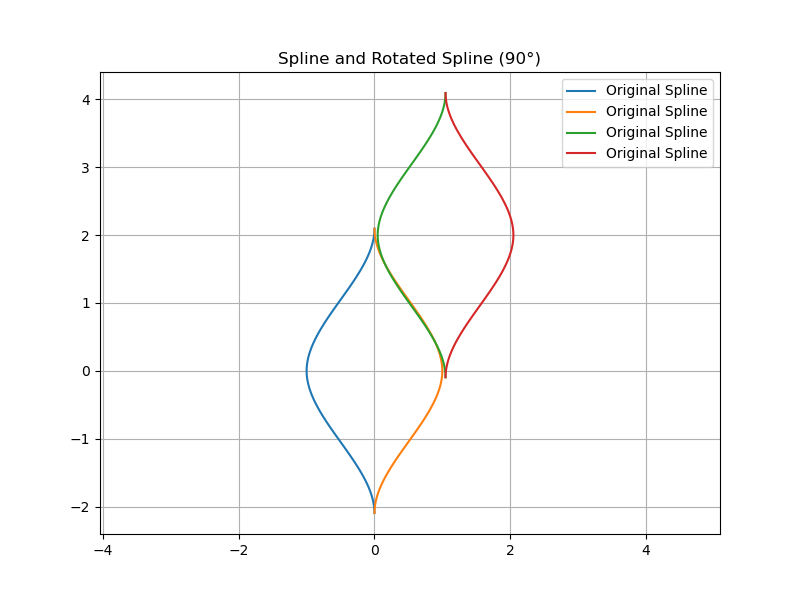

In [11]:
cylinder_radius = 2.0 
cylinder_height = 4.0 

max_length = np.pi * 2.0 * cylinder_radius 
n = 3 
m = 2 

dist1 = max_length / ( n * 2 )
dist2 = cylinder_height / ( m * 2 )

# Define control points
dist1_bis = ( np.sqrt( dist1*dist1 + dist2*dist2 ) / 2 ) * np.cos( np.atan( dist2 / dist1 ) ) ; 
dist2_bis = ( np.sqrt( dist1*dist1 + dist2*dist2 ) / 2 ) * np.sin( np.atan( dist2 / dist1 ) ) ; 

x = np.array([-dist1, -dist1_bis, 0, dist1_bis, dist1])
y = np.array([0, dist2_bis, dist2, dist2_bis, 0])

# Spline interpolation
spline_params = splrep(x, y)
x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = splev(x_smooth, spline_params)

# Create symmetric version
y_sym = -y_smooth
x_sym = x_smooth

# 90-degree rotation matrix
theta = np.pi / 2  # 90 degrees in radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]])
# Stack the points as (2, N)
original_points = np.vstack((x_smooth, y_smooth))
original_points_sym = np.vstack((x_sym, y_sym))

# Apply rotation
rotated_points = rotation_matrix @ original_points
rotated_points_sym = rotation_matrix  @ original_points_sym
x_rotated, y_rotated = rotated_points
x_rotated_sym, y_rotated_sym = rotated_points_sym

curve1 = np.stack((x_rotated, y_rotated))
curve2 = np.stack((x_rotated_sym, y_rotated_sym))
curve3 = np.stack((x_rotated + dist1/2 , y_rotated + dist2*2))
curve4 = np.stack((x_rotated_sym + dist1/2 , y_rotated_sym + dist2*2))
curves = [curve1, curve2, curve3, curve4]

plt.figure(figsize=(8, 6))
for i in range( len( curves )):
    plt.plot(curves[i][0], curves[i][1], '-', label='Original Spline')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title("Spline and Rotated Spline (90°)")
plt.show()

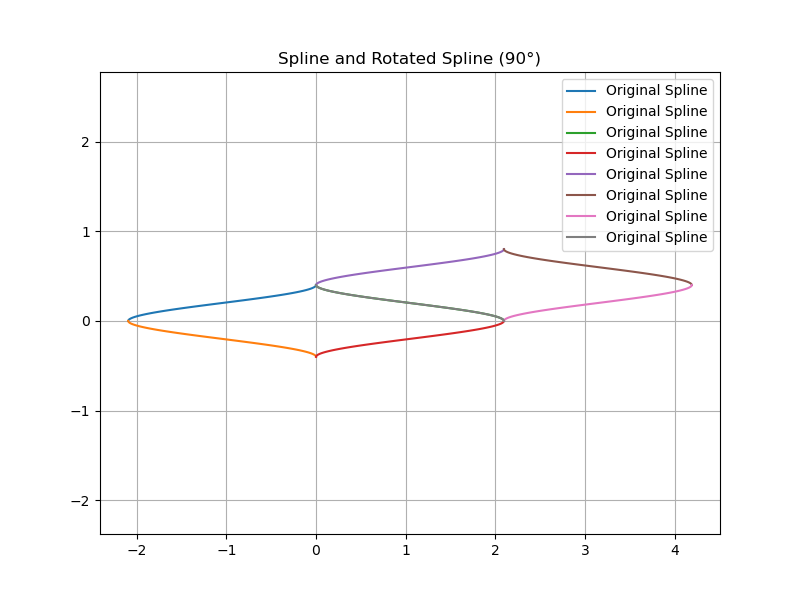

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

cylinder_radius = 2.0 
cylinder_height = 4.0 

max_length = np.pi * 2.0 * cylinder_radius 
n = 3 
m = 5

dist1 = cylinder_height / ( m * 2 )
dist2 = max_length / ( n * 2 )

# Define control points
dist1_bis = ( np.sqrt( dist1*dist1 + dist2*dist2 ) / 2 ) * np.cos( np.atan( dist2 / dist1 ) ) ; 
dist2_bis = ( np.sqrt( dist1*dist1 + dist2*dist2 ) / 2 ) * np.sin( np.atan( dist2 / dist1 ) ) ; 

x = np.array([-dist1, -dist1_bis, 0, dist1_bis, dist1])
y = np.array([0, dist2_bis, dist2, dist2_bis, 0])

# Spline interpolation
spline_params = splrep(x, y)
x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = splev(x_smooth, spline_params)

# Create symmetric version
y_sym = -y_smooth
x_sym = x_smooth

# 90-degree rotation matrix
theta = np.pi / 2  # 90 degrees in radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]])
# Stack the points as (2, N)
original_points = np.vstack((x_smooth, y_smooth))
original_points_sym = np.vstack((x_sym, y_sym))

# Apply rotation
rotated_points = rotation_matrix @ original_points
rotated_points_sym = rotation_matrix  @ original_points_sym
x_rotated, y_rotated = rotated_points
x_rotated_sym, y_rotated_sym = rotated_points_sym

mask1 = (x_rotated < 0 ) & (x_rotated > -dist2 ) & ( y_rotated > 0) & ( y_rotated < dist1 )
curve1 = np.stack((x_rotated[mask1], y_rotated[mask1]))
start_point = np.array([[-dist2], [0]])
end_point = np.array([[0], [dist1]])
curve1 = np.hstack((start_point, curve1, end_point))

mask2 = (x_rotated < 0 ) & (x_rotated > -dist2 ) & ( y_rotated < 0) & ( y_rotated > -dist1 )
curve2 = np.stack((x_rotated[mask2], y_rotated[mask2]))
start_point = np.array([[0], [-dist1]])
end_point = np.array([[-dist2], [0]])
curve2 = np.hstack((start_point, curve2, end_point))

curve3 = np.stack((x_rotated_sym[mask1], y_rotated_sym[mask1]))
end_point = np.array([[0], [dist1]])
start_point = np.array([[dist2], [0]])
curve3 = np.hstack((start_point, curve3, end_point))

curve4 = np.stack((x_rotated_sym[mask2], y_rotated_sym[mask2]))
end_point = np.array([[dist2], [0]])
start_point = np.array([[0], [-dist1]])
curve4 = np.hstack((start_point, curve4, end_point))

curves = [curve1, curve2, curve3, curve4]

curve21 = np.vstack((
    curves[0][0][1:-1] + dist2,
    curves[0][1][1:-1] + dist1
))

start_point = np.array([[0], [dist1]])
end_point = np.array([[dist2], [2*dist1]])
curve21 = np.hstack((start_point , curve21, end_point))

curve22 = np.vstack((
    curves[2][0][1:-1] + dist2,
    curves[2][1][1:-1] + dist1
))

start_point = np.array([[2*dist2], [dist1]])
end_point = np.array([[dist2], [2*dist1]])
curve22 = np.hstack((start_point , curve22, end_point))

curve23 = np.vstack((
    curves[3][0][1:-1] + dist2,
    curves[3][1][1:-1] + dist1
))

end_point = np.array([[2*dist2], [dist1]])
start_point = np.array([[dist2], [0]])
curve23 = np.hstack((start_point , curve23, end_point))

curve24 = np.vstack((
    curves[1][0][1:-1] + dist2,
    curves[1][1][1:-1] + dist1
))

end_point = np.array([[0], [dist1]])
start_point = np.array([[dist2], [0]])
curve24 = np.hstack((start_point , curve24, end_point))

curves.append(curve21)
curves.append(curve22)
curves.append(curve23)
curves.append(curve24)


plt.figure(figsize=(8, 6))
for i in range(8):
    plt.plot(curves[i][0], curves[i][1], '-', label='Original Spline')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title("Spline and Rotated Spline (90°)")
plt.show()

In [88]:
shared_point2

array([[1.99999990e+00],
       [6.36758921e-04],
       [1.01010101e+00]])

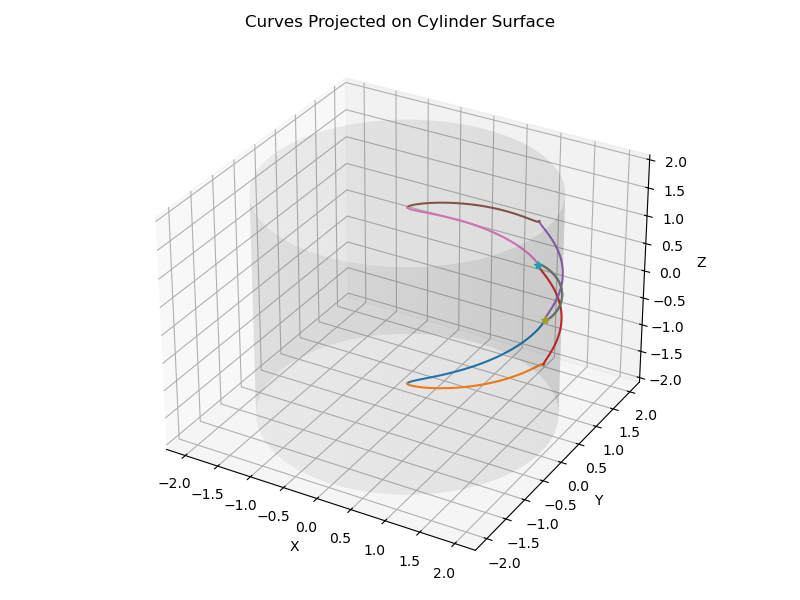

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget 

curves_cylinder = []


for curve in curves:
    curve_projected = []
    theta = curve[0] / cylinder_radius 
    X = cylinder_radius * np.cos( theta )
    Y = cylinder_radius * np.sin( theta )
    Z = curve[1]
    curve_projected.append((X,Y,Z))
    curve_projected_stack = np.column_stack(curve_projected)
    curves_cylinder.append(curve_projected_stack)

# shared_point = np.array([curves_cylinder[0][0][-1], curves_cylinder[0][1][-1], curves_cylinder[0][2][-1]])
# # shared_point2 = np.array([curves_cylinder[4][0][0], curves_cylinder[4][1][0], curves_cylinder[4][2][0]])
# curves_cylinder = np.hstack((shared_point, curves_cylinder))

# Get the shared point (last point of curves_cylinder[0])
shared_point = curves_cylinder[0][:, -1].reshape(3, 1)  # Shape: (3, 1)
shared_point2 = curves_cylinder[3][:, -1].reshape(3, 1)  # Shape: (3, 1)

# Prepend it to curves_cylinder[4]
# curves_cylinder[4] = np.hstack((shared_point, curves_cylinder[4]))
# curves_cylinder[6] = np.hstack((shared_point2, curves_cylinder[6]))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for curve in curves_cylinder:
    x, y, z = curve[0], curve[1], curve[2]
    ax.plot3D(x, y, z)

# Draw the cylinder
theta_cyl = np.linspace(0, 2 * np.pi, 100)
z_cyl = np.linspace(-cylinder_height/2, cylinder_height/2, 100)
theta_cyl, z_cyl = np.meshgrid(theta_cyl, z_cyl)
x_cyl = cylinder_radius * np.cos(theta_cyl)
y_cyl = cylinder_radius * np.sin(theta_cyl)

ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')
ax.plot3D(shared_point[0], shared_point[1], shared_point[2], "*")
ax.plot3D(shared_point2[0], shared_point2[1], shared_point2[2], "*")


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Curves Projected on Cylinder Surface')
plt.tight_layout()
plt.show()

In [15]:
# Step 5: Read the Fusion 360 script
with open('elastica.py', 'r') as file:
    lines = file.readlines()

# Step 6: Locate code generation section
start_idx = None
end_idx = None

for i, line in enumerate(lines):
    if '# START CODE GENERATION SECTION DO NOT REMOVE COMMENTS' in line:
        start_idx = i
    if '# END CODE GENERATION SECTION DO NOT REMOVE COMMENTS' in line:
        end_idx = i

if start_idx is None or end_idx is None or start_idx >= end_idx:
    raise ValueError("Code generation section not found or improperly formatted.")

marker_to_var = {}  
generated_code = []
generated_code.append('\n')
for i in range(len(curves_cylinder)):
    generated_code.append(f'        sketch{i} = sketches.add(rootComp.xYConstructionPlane)\n')
    generated_code.append(f'        sketch{i}.is3D = True\n')
    generated_code.append(f'        pts{i} = adsk.core.ObjectCollection.create()\n')
    for j in range(len(curves_cylinder[i][0])):
        var_name = f'p{i}_{j}'
        generated_code.append(f'        pts{i}.add(adsk.core.Point3D.create({curves_cylinder[i][0][j]}, {curves_cylinder[i][1][j]}, {curves_cylinder[i][2][j]}))\n')
    generated_code.append(f'        spline{i} = sketch{i}.sketchCurves.sketchFittedSplines.add(pts{i})\n')
    generated_code.append('\n\n')

# for j in range(len(curve3[0])):
#     generated_code.append(f'        pts{3}.add(adsk.core.Point3D.create({curve3[0][j]}, {curve3[1][j]}, {curve3[2][j]}))\n')
# generated_code.append(f'        spline{3} = sketch{3}.sketchCurves.sketchFittedSplines.add(pts{3})\n')
# generated_code.append('\n\n')
        
# generated_code.append('\n\n')

i = 0 

generated_code.append(f'        pathCurves{i} = adsk.core.ObjectCollection.create()\n')
generated_code.append(f'        pathCurves{i}.add(spline{0})\n')
generated_code.append(f'        pathCurves{i}.add(spline{2})\n')
generated_code.append(f'        pathCurves{i}.add(spline{3})\n')
generated_code.append(f'        pathCurves{i}.add(spline{1})\n')
generated_code.append('\n\n')

generated_code.append(f'        patches = rootComp.features.patchFeatures\n')
generated_code.append(f'        patchInput = patches.createInput(pathCurves{i}, adsk.fusion.FeatureOperations.NewBodyFeatureOperation)\n')
generated_code.append(f'        patch{i} = patches.add(patchInput)\n')

generated_code.append('\n\n')

i = 1 

generated_code.append(f'        pathCurves{i} = adsk.core.ObjectCollection.create()\n')
generated_code.append(f'        pathCurves{i}.add(spline{4})\n')
generated_code.append(f'        pathCurves{i}.add(spline{5})\n')
generated_code.append(f'        pathCurves{i}.add(spline{6})\n')
generated_code.append(f'        pathCurves{i}.add(spline{7})\n')
generated_code.append('\n\n')

generated_code.append(f'        patches = rootComp.features.patchFeatures\n')
generated_code.append(f'        patchInput = patches.createInput(pathCurves{i}, adsk.fusion.FeatureOperations.NewBodyFeatureOperation)\n')
generated_code.append(f'        patch{i} = patches.add(patchInput)\n')

generated_code.append('\n')


new_lines = lines[:start_idx + 1] + generated_code + lines[end_idx:]

with open('elastica.py', 'w') as file:
    file.writelines(new_lines)